In [1]:
from writers import CSV
from analyzers import DatasetEntropyAnalyzer
from datasets import TomographyArrayDownsampled
from utils.data_factory import DataFactory
from image_processing_pipelines import ThresholdClusterPipeline
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sympy as sp

In [2]:
# Sets up a tomography to pull slices from
print("Compiling Dataset...")
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Hylemonella gracilis/yc2013-01-03-21/Bdel_Hyle_0020009_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Brucella_abortus/aba2014-03-17-41/BrucellaWT0009_part121_8.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/good/FromGeorges_FastTilt/17/BD_1deg_2um_Aug25_15.30.48_af_combined_SIRT_1k.ctf.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Agrobacterium_tumefaciens_MS/Agrobacterium_MS_try2/et2014-03-05-15/4_pJW58_20008_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/CaulobacterCrescentus_UnpluggedPL/lza2018-10-20-13/targ65_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/good/FromGeorges_FastTilt/17/BD_1deg_2um_Aug25_15.30.48_af_combined_SIRT_1k.ctf.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d4/nobackup/archive/copick_root/ExperimentRuns/sma2022-03-21-50/sm3_21VibrioWT_049_rec.mrc"
tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d2/nobackup/archive/TomoDB1_d2/FlagellarMotor_P2/Proteus_mirabilis/qya2015-11-19-12/atlas3_at20002_part121_54.rec"
data = TomographyArrayDownsampled([tomo_path], factor=5)

Compiling Dataset...
Initialized with 1 files.


In [3]:
# Sets up an analysis pipeline
print("Setting up Analysis Pipeline...")
analyzer = DatasetEntropyAnalyzer()

Setting up Analysis Pipeline...


In [4]:
# Sets up a writer
print("Setting up Writer...")
writer = CSV("dataset_means_analysis.csv")

Setting up Writer...
The file dataset_means_analysis.csv is empty. Starting with a new DataFrame.


In [5]:
print("Configuring Processor...")
batch_size = 1
data_factory = DataFactory(
    analyzer,
    writer,
    batch_size
)

Configuring Processor...


In [6]:
print("Processing Data...")
results = data_factory.process(data, "Processing Slice")

Processing Data...


Processing Slice: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Now we want to plot the entropy analysis in a graph, just like the means analyzer.

In [7]:
degree = 7 # Degree of the polynomial to fit
save_path = "presentation_videos/sma2022-03-21-50"
tomo = results[tomo_path]["data"]
tomo_prehist = results[tomo_path]["data_pre"]
print(tomo.shape)

(100, 185, 192)


In [8]:
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 100  # Set the limit to 100 MB (adjust as needed)

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import ipywidgets as widgets

def plot_in_notebook(array, num_slices=10, save_path=None, custom_name=None, speed_factor=2, show_in_notebook=False):
    """
    Plot a 3D numpy array as animated slices with average of specified number of slices.
    The animations are 30% smaller and use grayscale, and only the shortest axis is plotted.
    
    Parameters:
    - array: 3D numpy array to plot
    - num_slices: Number of slices to average in each frame
    - save_path: Directory path to save the animations as videos. If None, videos are not saved.
    - custom_name: Custom name to be included in the saved video file name and the plot title.
    - speed_factor: A multiplier to control the speed of the animation (higher value means faster animation).
    - show_in_notebook: Boolean flag to control whether the animation is displayed in the notebook or not.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    def update_plot(frame, axis, ax):
        ax.cla()  # Clear the current plot
        
        if axis == 0:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[start_slice:end_slice, :, :]
            slice_ = np.mean(slices, axis=0)
            xlabel, ylabel = 'x', 'y'
        elif axis == 1:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, start_slice:end_slice, :]
            slice_ = np.mean(slices, axis=1)
            xlabel, ylabel = 'z', 'y'
        elif axis == 2:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, :, start_slice:end_slice]
            slice_ = np.mean(slices, axis=2)
            xlabel, ylabel = 'z', 'x'
        
        im = ax.imshow(slice_, cmap='gray', animated=True, origin='lower')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Set the plot title using custom_name if provided, else use a default title
        plot_title = f'{custom_name}' if custom_name else f'Axis {axis} ({"z" if axis == 0 else "x" if axis == 1 else "y"}) Slice {frame}'
        ax.set_title(plot_title)
        
        return [im]

    # Plot only along the shortest axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Calculate the interval in milliseconds, with speed_factor adjusting the speed
    interval = max(10, int(100 / speed_factor))  # 100ms is the default, and higher speed_factor means shorter interval
    
    ani = FuncAnimation(
        fig, update_plot, frames=array.shape[shortest_axis], 
        fargs=(shortest_axis, ax), blit=True, repeat=False, interval=interval
    )
    plt.close(fig)  # Close the figure to prevent it from displaying statically

    # Save the animation if save_path is provided
    if save_path is not None:
        # Ensure the save_path directory exists
        os.makedirs(save_path, exist_ok=True)
        axis_names = ['z', 'x', 'y']
        
        # Set the custom name or default to 'animation_axis'
        base_name = f'animation_axis_{axis_names[shortest_axis]}'
        if custom_name:
            base_name += f'_{custom_name}'
        
        video_filename = os.path.join(save_path, f'{base_name}.mp4')
        ani.save(video_filename, writer='ffmpeg', dpi=100)
        print(f"Saved animation for axis {axis_names[shortest_axis]} to {video_filename}")

    # Optionally display the animation in the notebook
    if show_in_notebook:
        output = widgets.Output()
        with output:
            display(HTML(ani.to_jshtml()))
        display(output)




In [9]:
import numpy as np

def bit_plane_slicing_3d(array):
    """
    Perform bit-plane slicing on a 3D numpy array.
    
    If the input array is not of dtype np.uint8, it will be normalized to the 0-255 range
    and converted to np.uint8 before bit-plane slicing.
    
    Parameters:
    - array: 3D numpy array of any dtype.
    
    Returns:
    - 8 numpy arrays, one for each bit-plane from 0 (LSB) to 7 (MSB).
    """
    # Check if the array is already of type np.uint8
    if array.dtype != np.uint8:
        # Normalize the array to the 0-255 range
        array_min = array.min()
        array_max = array.max()
        
        if array_max == array_min:
            raise ValueError("The array has no variation (all values are the same), normalization is not possible.")
        
        array_normalized = (array - array_min) / (array_max - array_min) * 255
        array_uint8 = array_normalized.astype(np.uint8)
    else:
        array_uint8 = array
    
    # Extract each bit-plane by shifting and masking
    bit_planes = [(array_uint8 >> bit) & 1 for bit in range(8)]
    
    # Return each bit-plane as a separate numpy array
    return tuple(bit_planes)


bit_plane_0, bit_plane_1, bit_plane_2, bit_plane_3, bit_plane_4, bit_plane_5, bit_plane_6, bit_plane_7 = bit_plane_slicing_3d(tomo)


In [10]:
# plot_in_notebook(tomo, num_slices=10)
# plot_in_notebook(difference, num_slices=10)
# plot_in_notebook(tomo_prehist, num_slices=10)

In [18]:
# plot_in_notebook(bit_plane_0, save_path=save_path, custom_name="bit-plane(0)")
# plot_in_notebook(bit_plane_1, save_path=save_path, custom_name="bit-plane(1)")
# plot_in_notebook(bit_plane_2, save_path=save_path, custom_name="bit-plane(2)")
# plot_in_notebook(bit_plane_3, save_path=save_path, custom_name="bit-plane(3)")
# plot_in_notebook(bit_plane_4, save_path=save_path, custom_name="bit-plane(4)")
# plot_in_notebook(bit_plane_5, save_path=save_path, custom_name="bit-plane(5)")
# plot_in_notebook(bit_plane_6, save_path=save_path, custom_name="bit-plane(6)")
# plot_in_notebook(bit_plane_7, save_path=save_path, custom_name="bit-plane(7)")

plot_in_notebook(bit_plane_0+bit_plane_1+bit_plane_2+bit_plane_3, save_path=save_path, custom_name="compressed_tomo_bits_0_3")
 
compressed_tomo = bit_plane_4+bit_plane_5+bit_plane_6+bit_plane_7

plot_in_notebook(compressed_tomo, save_path=save_path, custom_name="compressed_tomo")
plot_in_notebook(tomo, save_path=save_path, custom_name="Tomo")

Saved animation for axis z to presentation_videos/sma2022-03-21-50/animation_axis_z_compressed_tomo_bits_0_3.mp4
Saved animation for axis z to presentation_videos/sma2022-03-21-50/animation_axis_z_compressed_tomo.mp4
Saved animation for axis z to presentation_videos/sma2022-03-21-50/animation_axis_z_Tomo.mp4


In [19]:
print(f"Size of compressed Tomogram: {compressed_tomo.nbytes}")
print(f"Size of normal Tomogram:     {tomo.nbytes}")
print((tomo.nbytes/compressed_tomo.nbytes))

Size of compressed Tomogram: 3552000
Size of normal Tomogram:     28416000
8.0


In [20]:

import numpy as np
from scipy.ndimage import label

def select_ranked_dark_group(array_3d, percentile=20, rank=1, connectivity=2):
    """
    Normalizes the 3D array, then selects a specific group of dark values based on size ranking.

    Parameters:
        array_3d (np.ndarray): The input 3D array.
        percentile (float): The percentile below which values are considered dark, after normalization.
        rank (int): The rank of the group to return based on size (1 for largest, 2 for second largest, etc.).
        connectivity (int): The connectivity criterion (1 for direct neighbors, 2 for diagonal neighbors).

    Returns:
        ranked_group_mask (np.ndarray): A binary mask of the same shape as array_3d, where the ranked dark group is marked as 1.
        ranked_group_size (int): The size of the ranked dark group.
        normalized_array (np.ndarray): The normalized array with values in the range [0, 1].
    """
    # Normalize the array to the range [0, 1]
    array_min = np.min(array_3d)
    array_max = np.max(array_3d)
    
    # Prevent division by zero in case all values are the same
    if array_max - array_min != 0:
        normalized_array = (array_3d - array_min) / (array_max - array_min)
    else:
        normalized_array = np.zeros_like(array_3d)

    # Calculate the dynamic threshold based on the specified percentile
    threshold = np.percentile(normalized_array, percentile)

    # Create a binary mask where normalized values below the threshold are marked as 1, others as 0
    dark_values_mask = normalized_array < threshold

    # Label connected components in the binary mask
    labeled_array, num_features = label(dark_values_mask, structure=np.ones((3, 3, 3)) if connectivity == 2 else None)

    if num_features == 0:
        print("No dark-value groups found.")
        return np.zeros_like(array_3d), 0, normalized_array  # Return an empty mask if no groups are found

    # Find all group sizes by counting occurrences of each label
    label_counts = np.bincount(labeled_array.flat)

    # Exclude the background label (index 0) and sort groups by size in descending order
    sorted_labels_and_sizes = sorted(enumerate(label_counts[1:], start=1), key=lambda x: x[1], reverse=True)

    if rank > len(sorted_labels_and_sizes):
        print(f"Rank {rank} exceeds the number of detected groups. Returning an empty mask.")
        return np.zeros_like(array_3d), 0, normalized_array  # Return an empty mask if rank is out of bounds

    # Get the label for the specified rank
    ranked_group_label, ranked_group_size = sorted_labels_and_sizes[rank - 1]

    # Create a mask for the ranked group
    ranked_group_mask = labeled_array == ranked_group_label

    return ranked_group_mask, ranked_group_size, normalized_array




In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import entropy
import os
from IPython.display import display, HTML
import ipywidgets as widgets

def mn_plot_in_notebook(array, num_slices=10, save_path=None, custom_name=None, speed_factor=2, show_in_notebook=False):
    """
    Plot a 3D numpy array as animated slices with average of specified number of slices.
    The animations are 30% smaller and use grayscale, and only the shortest axis is plotted.
    
    Parameters:
    - array: 3D numpy array to plot
    - num_slices: Number of slices to average in each frame
    - save_path: Directory path to save the animations as videos. If None, videos are not saved.
    - custom_name: Custom name to be included in the saved video file name and the plot title.
    - speed_factor: A multiplier to control the speed of the animation (higher value means faster animation).
    - show_in_notebook: Boolean flag to control whether the animation is displayed in the notebook or not.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    # Prepare lists to store entropy and mean values
    entropy_values = []
    mean_values = []
    
    # Variables to track the slice with the largest mean value
    max_mean_value = -np.inf
    max_mean_slice = -1

    def update_plot(frame, axis, ax):
        nonlocal max_mean_value, max_mean_slice  # Allow modifying the tracking variables
        
        ax.cla()  # Clear the current plot
        
        if axis == 0:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[start_slice:end_slice, :, :]
            slice_ = np.mean(slices, axis=0)
            xlabel, ylabel = 'x', 'y'
        elif axis == 1:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, start_slice:end_slice, :]
            slice_ = np.mean(slices, axis=1)
            xlabel, ylabel = 'z', 'y'
        elif axis == 2:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, :, start_slice:end_slice]
            slice_ = np.mean(slices, axis=2)
            xlabel, ylabel = 'z', 'x'
        
        # Calculate entropy and mean for the slice
        flattened_slice = slice_.flatten()
        slice_entropy = entropy(np.histogram(flattened_slice, bins=256)[0])
        mean_value = np.mean(slice_)
        
        # Append entropy and mean values to the lists
        entropy_values.append(slice_entropy)
        mean_values.append(mean_value)
        
        # Check if this slice has the largest mean value so far
        if mean_value > max_mean_value:
            max_mean_value = mean_value
            max_mean_slice = frame
        
        # Plot the slice
        im = ax.imshow(slice_, cmap='gray', animated=True, origin='lower')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Set the plot title using custom_name if provided, else use a default title
        plot_title = f'{custom_name}' if custom_name else f'Axis {axis} ({"z" if axis == 0 else "x" if axis == 1 else "y"}) Slice {frame}'
        ax.set_title(plot_title)
        
        # Display entropy and mean values on the plot, formatted to 5 decimal places
        ax.text(0.05, 0.95, f'Entropy: {slice_entropy:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
        ax.text(0.05, 0.90, f'Mean: {mean_value:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
        
        return [im]

    # Plot only along the shortest axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Calculate the interval in milliseconds, with speed_factor adjusting the speed
    interval = max(10, int(100 / speed_factor))  # 100ms is the default, and higher speed_factor means shorter interval
    
    ani = FuncAnimation(
        fig, update_plot, frames=array.shape[shortest_axis], 
        fargs=(shortest_axis, ax), blit=True, repeat=False, interval=interval
    )
    plt.close(fig)  # Close the figure to prevent it from displaying statically

    # Save the animation if save_path is provided
    if save_path is not None:
        # Ensure the save_path directory exists
        os.makedirs(save_path, exist_ok=True)
        axis_names = ['z', 'x', 'y']
        
        # Set the custom name or default to 'animation_axis'
        base_name = f'animation_axis_{axis_names[shortest_axis]}'
        if custom_name:
            base_name += f'_{custom_name}'
        
        video_filename = os.path.join(save_path, f'{base_name}.mp4')
        ani.save(video_filename, writer='ffmpeg', dpi=100)
        print(f"Saved animation for axis {axis_names[shortest_axis]} to {video_filename}")

    # Optionally display the animation in the notebook
    if show_in_notebook:
        output = widgets.Output()
        with output:
            display(HTML(ani.to_jshtml()))
        display(output)
    
    # Print or return the slice number with the largest mean value
    print(f"The slice with the largest mean value is slice number {max_mean_slice} with a mean value of {max_mean_value:.5f}")
    return max_mean_slice



In [22]:
def select_largest_dark_group(array_3d, threshold=0.2, connectivity=1):
    """
    Normalizes the 3D array, then selects the largest group of dark values based on a threshold.

    Parameters:
        array_3d (np.ndarray): The input 3D array.
        threshold (float): The threshold below which values are considered dark, after normalization.
        connectivity (int): The connectivity criterion (1 for direct neighbors, 2 for diagonal neighbors).

    Returns:
        largest_group_mask (np.ndarray): A binary mask of the same shape as array_3d, where the largest dark group is marked as 1.
        largest_group_size (int): The size of the largest dark group.
        normalized_array (np.ndarray): The normalized array with values in the range [0, 1].
    """
    # Normalize the array to the range [0, 1]
    array_min = np.min(array_3d)
    array_max = np.max(array_3d)
    
    # Prevent division by zero in case all values are the same
    if array_max - array_min != 0:
        normalized_array = (array_3d - array_min) / (array_max - array_min)
    else:
        normalized_array = np.zeros_like(array_3d)

    # Create a binary mask where normalized values below the threshold are marked as 1, others as 0
    dark_values_mask = normalized_array < threshold

    # Label connected components in the binary mask
    labeled_array, num_features = label(dark_values_mask, structure=np.ones((3, 3, 3)) if connectivity == 2 else None)

    if num_features == 0:
        print("No dark-value groups found.")
        return np.zeros_like(array_3d), 0, normalized_array  # Return an empty mask if no groups are found

    # Find the largest group by counting occurrences of each label
    label_counts = np.bincount(labeled_array.flat)
    
    # Exclude the background label (index 0)
    largest_group_label = label_counts[1:].argmax() + 1
    largest_group_size = label_counts[largest_group_label]

    # Create a mask for the largest group
    largest_group_mask = labeled_array == largest_group_label

    return largest_group_mask, largest_group_size, normalized_array

In [23]:
compressed_mask, a, b = select_ranked_dark_group(compressed_tomo, percentile= 10)
mn_plot_in_notebook(compressed_mask, save_path=save_path, custom_name="compressed_mask")
mask, a, b = select_ranked_dark_group(tomo, percentile= 10)
slice_num =  mn_plot_in_notebook(mask, save_path=save_path, custom_name="tomo_mask", show_in_notebook=True)

Saved animation for axis z to presentation_videos/sma2022-03-21-50/animation_axis_z_compressed_mask.mp4
The slice with the largest mean value is slice number 14 with a mean value of 0.01243
Saved animation for axis z to presentation_videos/sma2022-03-21-50/animation_axis_z_tomo_mask.mp4


Output()

The slice with the largest mean value is slice number 8 with a mean value of 0.13832


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os

def plot_specific_slice(array, slice_number, num_slices=10, custom_name=None, save_path=None):
    """
    Plot a specific slice of a 3D numpy array with entropy and mean value calculation.
    
    Parameters:
    - array: 3D numpy array to plot
    - slice_number: The specific slice number to plot (along the shortest axis).
    - num_slices: Number of slices to average around the specified slice.
    - custom_name: Custom name to be included in the plot title and saved file name.
    - save_path: Directory path to save the plot as an image. If None, the plot is not saved.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    # Ensure the slice_number is within valid range
    slice_number = np.clip(slice_number, 0, array.shape[shortest_axis] - 1)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    if shortest_axis == 0:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[start_slice:end_slice, :, :]
        slice_ = np.mean(slices, axis=0)
        xlabel, ylabel = 'x', 'y'
    elif shortest_axis == 1:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[:, start_slice:end_slice, :]
        slice_ = np.mean(slices, axis=1)
        xlabel, ylabel = 'z', 'y'
    elif shortest_axis == 2:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[:, :, start_slice:end_slice]
        slice_ = np.mean(slices, axis=2)
        xlabel, ylabel = 'z', 'x'
    
    # Calculate entropy and mean for the slice
    flattened_slice = slice_.flatten()
    slice_entropy = entropy(np.histogram(flattened_slice, bins=256)[0])
    mean_value = np.mean(slice_)
    
    # Plot the slice
    im = ax.imshow(slice_, cmap='gray', origin='lower')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set the plot title using custom_name if provided, else use a default title
    plot_title = f'{custom_name}' if custom_name else f'Axis {shortest_axis} Slice {slice_number}'
    ax.set_title(plot_title)
    
    # Display entropy and mean values on the plot, formatted to 5 decimal places
    ax.text(0.05, 0.95, f'Entropy: {slice_entropy:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
    ax.text(0.05, 0.90, f'Mean: {mean_value:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
    
    # Save the plot if save_path is provided
    if save_path is not None:
        # Ensure the save_path directory exists
        os.makedirs(save_path, exist_ok=True)
        axis_names = ['z', 'x', 'y']
        
        # Set the custom name or default to 'slice_axis'
        base_name = f'slice_axis_{axis_names[shortest_axis]}_slice_{slice_number}'
        if custom_name:
            base_name += f'_{custom_name}'
        
        # Save the plot as an image file
        image_filename = os.path.join(save_path, f'{base_name}.png')
        plt.savefig(image_filename, dpi=100)
        print(f"Saved plot for axis {axis_names[shortest_axis]}, slice {slice_number} to {image_filename}")
    
    # Show the plot
    plt.show()


Saved plot for axis z, slice 8 to presentation_videos/sma2022-03-21-50/slice_axis_z_slice_8_middle_mask.png


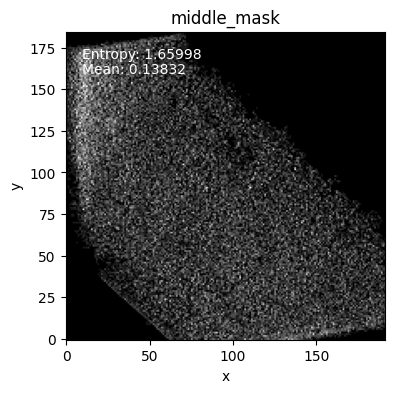

Saved plot for axis z, slice 8 to presentation_videos/sma2022-03-21-50/slice_axis_z_slice_8_middle_tomo.png


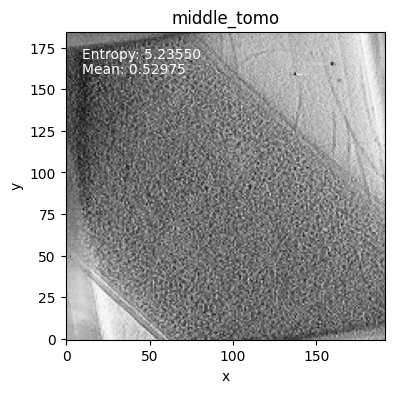

In [25]:
plot_specific_slice(mask, slice_number=slice_num, save_path=save_path, custom_name="middle_mask" )
plot_specific_slice(tomo, slice_number=slice_num, save_path=save_path, custom_name="middle_tomo" )